In [1]:
import astropy.units as u
import numpy as np
import yaml
import random
import sys
import scipy.optimize as opt
import matplotlib.pyplot as plt
# add dithering module to path and load it
sys.path.append('./../../py')
import dithering

dithering = dithering.dithering(config_file="../../config/desi-noblur-nooffset.yaml")

The results show that the distributions are gaussian. It should be noted that this is independent of the choice of the random offsets even though it may seem so. The random offset distributions manifest on the number of events in each bin of the 2D histogram (shown in color bars)

That having established, the script below randomly moves the fiber off the focal coordinates; then using the distributions above, the fiber will be moved 3 times (corresponding to 3 exposures) to find the correct focal coordinates maximizing SNR.

In [2]:
# define the source to be observed
source_type       = "lrg"
half_light_radius = 0.7
source_alt = 11.
source_az  = 13.

# define the observing conditions
boresight_alt = 10.
boresight_az  = 12.

# generate the random offset but not reveal it to user until the end
x_offset = random.gauss(0, 1.) * 30.
y_offset = random.gauss(0, 1.) * 30.

In [3]:
# Generate the source to be observed
if source_type == "qso" or source_type == "QSO":
    source    = dithering.generate_source(disk_fraction=0., bulge_fraction=0., 
                                          half_light_disk=0., half_light_bulge=0.)
elif source_type == "elg" or source_type == "ELG":
    source    = dithering.generate_source(disk_fraction=1., bulge_fraction=0., 
                                          half_light_disk=half_light_radius, half_light_bulge=0.)
elif source_type == "lrg" or source_type == "LRG":
    source    = dithering.generate_source(disk_fraction=0., bulge_fraction=1., 
                                          half_light_disk=0., half_light_bulge=half_light_radius)

In [4]:
dithering.set_boresight_position(boresight_alt*u.deg, boresight_az*u.deg)
dithering.set_source_position(source_alt*u.deg, source_az*u.deg)
dithering.set_focal_plane_position()
dithering.set_theta_0(-5.*u.deg)
dithering.set_phi_0(10.*u.deg)
SNR = []
x   = []
y   = []

# initial point
dithering.place_fiber([x_offset, y_offset])
dithering.run_simulation(source_type, *source, report=False)
SNR.append(np.median(dithering.SNR['b'][0]))
x.append(0)
y.append(0)
# dithering
num_dithering = 5
search_radia = [35., 70.]
for i in range(num_dithering):
    x_dither = search_radia[0] * np.cos((360./num_dithering)*i*u.deg)
    y_dither = search_radia[0] * np.sin((360./num_dithering)*i*u.deg)
    dithering.place_fiber([x_offset+x_dither, y_offset+y_dither])
    dithering.run_simulation(source_type, *source, report=False)
    SNR.append(np.median(dithering.SNR['b'][0]))
    x.append(x_dither)
    y.append(y_dither)
    x_dither = search_radia[1] * np.cos((360./num_dithering)*i*u.deg)
    y_dither = search_radia[1] * np.sin((360./num_dithering)*i*u.deg)
    dithering.place_fiber([x_offset+x_dither, y_offset+y_dither])
    dithering.run_simulation(source_type, *source, report=False)
    SNR.append(np.median(dithering.SNR['b'][0]))
    x.append(x_dither)
    y.append(y_dither)

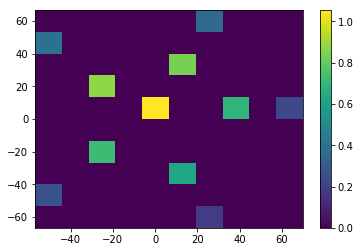

In [5]:
plt.hist2d(x, y, weights=SNR, bins=num_dithering*2)
plt.colorbar()
plt.show()

In [6]:
def twoD_Gaussian(xy_tuple, amplitude, xo, yo):
    (x, y) = xy_tuple
    xo = float(xo)
    yo = float(yo)
    amplitude = float(amplitude)
    sigma_x = 70
    sigma_y = 70
    g = amplitude * np.exp( - ( (x-xo)**2/(2*sigma_x**2) + (y-yo)**2/(2*sigma_y**2) ) )#            ((x-xo)/sigma_x**2) - ((y-yo)/sigma_y**2))
    return g.ravel()

In [7]:
coordinates = np.vstack((np.array(x).ravel(), np.array(y).ravel()))
data = np.array(SNR).ravel()
initial_guess = (2., -5., -5.)
popt, pcov = opt.curve_fit(twoD_Gaussian, coordinates, data, p0=initial_guess)
print("Optimization found the following:")
dithering.place_fiber([x_offset+popt[1], y_offset+popt[2]])
dithering.run_simulation(source_type, *source, report=True)
print("If there was not error (offset):")
dithering.place_fiber([0., 0.])
dithering.run_simulation(source_type, *source, report=True)

Optimization found the following:
boresight position is   : 10.000 deg , 12.000 deg
source position is      : 11.000 deg , 13.000 deg
fiber position is       : 248.752 mm , 253.785 mm
focal plane position is : 248.752 mm , 253.785 mm
fiber placement         : -2.825495130994697 um, 5.696235675009897 um
With the current configuration, SNR are:
-- camera b: 1.077 / 0.5 Angstrom
-- camera r: 0.858 / 0.5 Angstrom
-- camera z: 0.625 / 0.5 Angstrom
If there was not error (offset):
boresight position is   : 10.000 deg , 12.000 deg
source position is      : 11.000 deg , 13.000 deg
fiber position is       : 248.752 mm , 253.785 mm
focal plane position is : 248.752 mm , 253.785 mm
fiber placement         : 0.0 um, 0.0 um
With the current configuration, SNR are:
-- camera b: 1.102 / 0.5 Angstrom
-- camera r: 0.877 / 0.5 Angstrom
-- camera z: 0.639 / 0.5 Angstrom
